# Medical Appointments No-Show Prediction

## 1- Objective

The main goal of this project is to try to predict if patients are going to attend to their meeting with the doctor or not. In order to do so, we will use a public dataset containing data of more that 110,000 appointments related to around 62,000 patients.

## 2- Data exploration

We will start with the data exploration and cleaning:

In [1]:
# We start by importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# We then import the data set and start exploring it:
appointments = pd.read_csv('../../data/KaggleV2-May-2016.csv',index_col=1)
appointments.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
5642503,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
5642549,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
5642828,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5642494,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# I first observe and transform my dependent variable (No-show):
appointments_raw = appointments.copy()
print(appointments['No-show'].value_counts())
appointments['No-show'] = [0 if app == "No" else 1 for app in appointments['No-show']]
print(appointments['No-show'].value_counts())

No     88208
Yes    22319
Name: No-show, dtype: int64
0    88208
1    22319
Name: No-show, dtype: int64


In [4]:
# I then look at the rest of the dataset:
appointments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5642903 to 5629448
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   Gender          110527 non-null  object 
 2   ScheduledDay    110527 non-null  object 
 3   AppointmentDay  110527 non-null  object 
 4   Age             110527 non-null  int64  
 5   Neighbourhood   110527 non-null  object 
 6   Scholarship     110527 non-null  int64  
 7   Hipertension    110527 non-null  int64  
 8   Diabetes        110527 non-null  int64  
 9   Alcoholism      110527 non-null  int64  
 10  Handcap         110527 non-null  int64  
 11  SMS_received    110527 non-null  int64  
 12  No-show         110527 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 11.8+ MB


In [5]:
# We will now transform the Gender to an integer:
print(appointments.Gender.value_counts())
appointments.Gender = [0 if g == 'F' else 1 for g in appointments.Gender]
print(appointments.Gender.value_counts())

F    71840
M    38687
Name: Gender, dtype: int64
0    71840
1    38687
Name: Gender, dtype: int64


In [6]:
# We now convert the date columns to datetime format and separate to date and time:
appointments['ScheduledDate'] = [d.date() for d in pd.to_datetime(appointments['ScheduledDay'])]
appointments['ScheduledTime'] = [d.time() for d in pd.to_datetime(appointments['ScheduledDay'])]
appointments['AppointmentDate'] = [d.date() for d in pd.to_datetime(appointments['AppointmentDay'])]
appointments['AppointmentTime'] = [d.time() for d in pd.to_datetime(appointments['AppointmentDay'])]
appointments['AppointmentTime'].value_counts()

00:00:00    110527
Name: AppointmentTime, dtype: int64

In [7]:
#As we can observe in the cell above, appointment dates are not well saved si we will frop the time columns and the original dates:
appointments.drop(columns=['AppointmentDay','ScheduledDay','AppointmentTime','ScheduledTime'],inplace = True)
appointments.head()

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDate,AppointmentDate
AppointmentID,,,,,,,,,,,,,
5642903,2.987250e+13,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,2016-04-29
5642503,5.589978e+14,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,2016-04-29
5642549,4.262962e+12,0,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29,2016-04-29
5642828,8.679512e+11,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29,2016-04-29
5642494,8.841186e+12,0,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29,2016-04-29


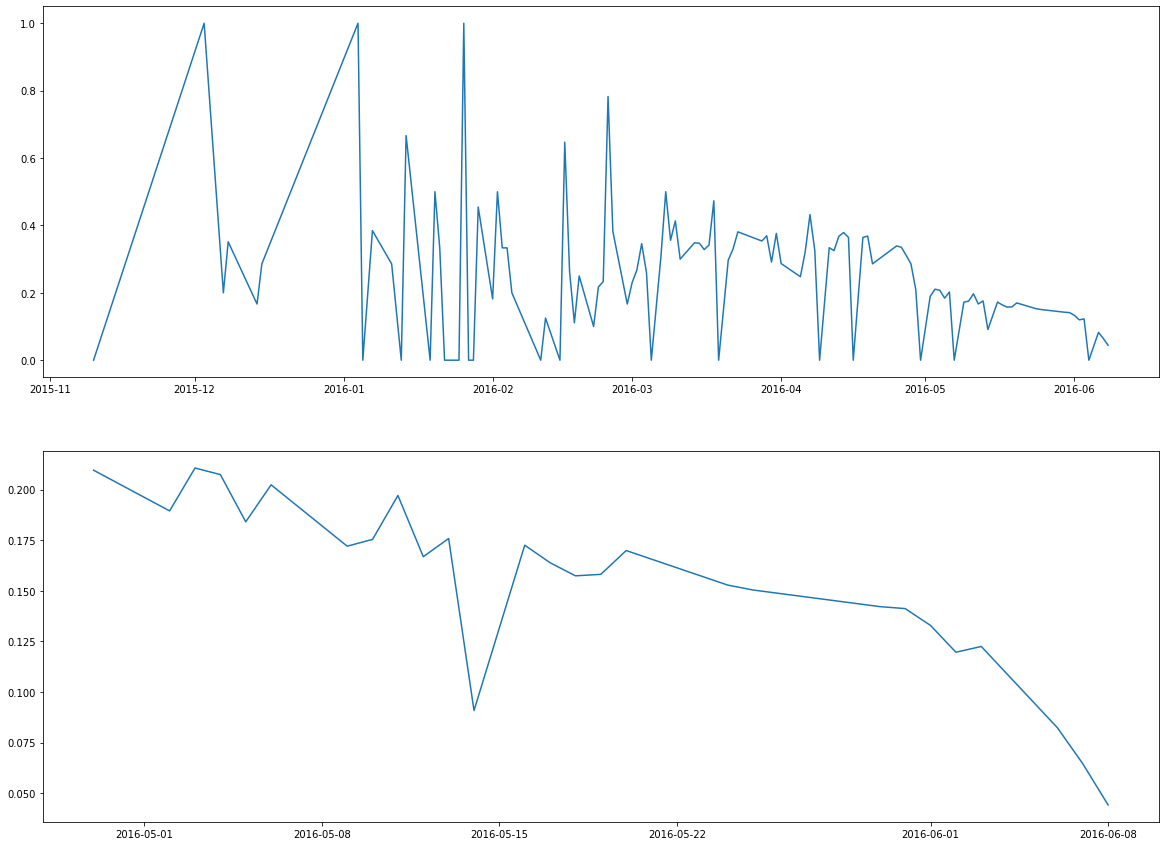

In [8]:
# I will now take a look at the seasonality of no-shows:
scheduled_dates = appointments[['ScheduledDate','No-show']].groupby('ScheduledDate',as_index=False).agg(['sum','count'])
appointment_dates = appointments[['AppointmentDate','No-show']].groupby('AppointmentDate',as_index=False).agg(['sum','count'])
scheduled_dates['Ratio'] = scheduled_dates['No-show']['sum'] / scheduled_dates['No-show']['count']
appointment_dates['Ratio'] = scheduled_dates['No-show']['sum'] / scheduled_dates['No-show']['count']
fig, ax = plt.subplots(2,1, figsize = (20,15))
ax[0].plot(scheduled_dates['Ratio'])
ax[1].plot(appointment_dates['Ratio'])
plt.show()

In [9]:
#From the previous analysis, I can observe that maybe the day of the week and the time difference between schedule and appointment have an impact:
appointments['Time difference'] = appointments['AppointmentDate'] - appointments['ScheduledDate']
appointments['Time difference'] = [d.days for d in appointments['Time difference']]
appointments.drop(columns='ScheduledDate',inplace=True)
appointments['App. week day'] = [d.weekday() for d in appointments['AppointmentDate']]
appointments.drop(columns='AppointmentDate',inplace=True)

In [10]:
# I look again at the correlations between No-show and the independent variables:
appointments.corr()['No-show'].drop('No-show').sort_values(ascending=False)

Time difference    0.186231
SMS_received       0.126431
Scholarship        0.029135
App. week day      0.001165
Alcoholism        -0.000196
PatientId         -0.001461
Gender            -0.004119
Handcap           -0.006076
Diabetes          -0.015180
Hipertension      -0.035701
Age               -0.060319
Name: No-show, dtype: float64

In [13]:
# Even if the PatientId presents a low correlation with No-show, I will calculate, for each patient, its ratio of no-shows in the past:
appointments.reset_index(drop=True,inplace=True)

In [14]:
appointments['Previous visits'] = [appointments.iloc[:i][appointments['PatientId'] == appointments['PatientId'][i]]['No-show'].count() 
                                   for i in range(len(appointments))]
appointments

/usr/local/Cellar/jupyterlab/2.1.0/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time difference,App. week day,Previous visits
0,2.987250e+13,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,4,0
1,5.589978e+14,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,4,0
2,4.262962e+12,0,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,4,0
3,8.679512e+11,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,4,0
4,8.841186e+12,0,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,0,56,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,1
110523,3.596266e+12,0,51,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,3
110524,1.557663e+13,0,21,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0
110525,9.213493e+13,0,38,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,1


In [15]:
appointments['Previous no-shows'] = [appointments.iloc[:i][appointments['PatientId'] == appointments['PatientId'][i]]['No-show'].sum() 
                                   for i in range(len(appointments))]
appointments

/usr/local/Cellar/jupyterlab/2.1.0/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time difference,App. week day,Previous visits,Previous no-shows
0,2.987250e+13,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,4,0,0
1,5.589978e+14,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,4,0,0
2,4.262962e+12,0,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,4,0,0
3,8.679512e+11,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,4,0,0
4,8.841186e+12,0,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,0,56,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,1,1
110523,3.596266e+12,0,51,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,3,1
110524,1.557663e+13,0,21,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0,0
110525,9.213493e+13,0,38,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,1,0


In [16]:
appointments['Patient ratio'] = appointments['Previous no-shows'] / appointments['Previous visits']
appointments.drop(columns='Previous no-shows',inplace=True)
appointments.fillna(0,inplace=True)
appointments

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time difference,App. week day,Previous visits,Patient ratio
0,2.987250e+13,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,4,0,0.000000
1,5.589978e+14,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,4,0,0.000000
2,4.262962e+12,0,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,4,0,0.000000
3,8.679512e+11,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,4,0,0.000000
4,8.841186e+12,0,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,4,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,0,56,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,1,1.000000
110523,3.596266e+12,0,51,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,3,0.333333
110524,1.557663e+13,0,21,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0,0.000000
110525,9.213493e+13,0,38,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,1,0.000000


In [17]:
#I drop the PatientId and look at the new correlations with the no-shows:
appointments.drop('PatientId',axis=1,inplace=True)
appointments.corr()['No-show'].sort_values(ascending=False)

No-show            1.000000
Time difference    0.186231
SMS_received       0.126431
Patient ratio      0.106092
Scholarship        0.029135
App. week day      0.001165
Alcoholism        -0.000196
Gender            -0.004119
Handcap           -0.006076
Diabetes          -0.015180
Previous visits   -0.023049
Hipertension      -0.035701
Age               -0.060319
Name: No-show, dtype: float64

In [24]:
#I create a version of the dataset with the weekdays for the following plotting of the data:
def weekdays(df):
    df['App. week day'] = ['Monday' if d == 0 else 'Tuesday' if d == 1 else 'Wednesday' if d == 2 else 'Thursday' if d == 3 else 'Friday' if d == 4 else 'Saturday' for d in df['App. week day']]
    return df
appointments_with_weekdays = weekdays(appointments)
appointments_with_weekdays['No-show text'] = ['Yes' if ns == 1 else 'No' for ns in appointments_with_weekdays['No-show']]
appointments_with_weekdays.to_excel('Data_for_plotting.xlsx')

In [57]:
#I will finally look at the neighbourhoods, take the top ones and dummify them:
neighbourhoods = appointments[['Neighbourhood','No-show']].groupby('Neighbourhood',as_index=False).count().sort_values(by='No-show',ascending=False).reset_index(drop=True)
neighbourhoods.head(10)

,Neighbourhood,No-show
0,JARDIM CAMBURI,7717
1,MARIA ORTIZ,5805
2,RESISTÊNCIA,4431
3,JARDIM DA PENHA,3877
4,ITARARÉ,3514
5,CENTRO,3334
6,TABUAZEIRO,3132
7,SANTA MARTHA,3131
8,JESUS DE NAZARETH,2853
9,BONFIM,2773


<BarContainer object of 81 artists>

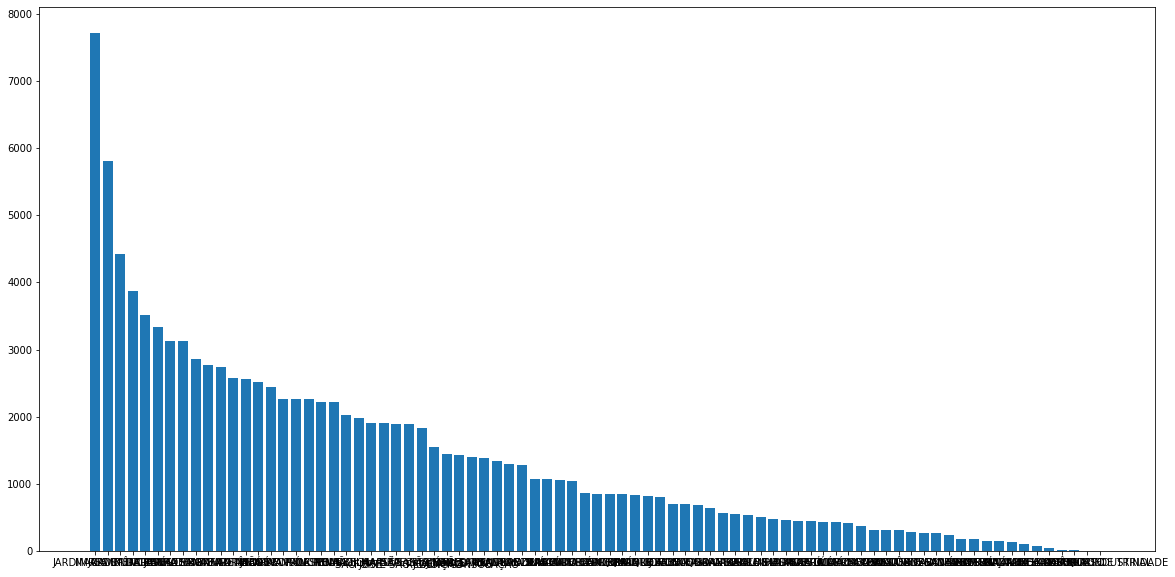

In [58]:
plt.figure(figsize=(20,10))
plt.bar(neighbourhoods['Neighbourhood'],neighbourhoods['No-show'])

In [59]:
neighbourhoods['No-show'][:15].sum()/neighbourhoods['No-show'].sum()

0.48319415165525165

In [60]:
top_10_neigh = list(neighbourhoods['Neighbourhood'][:10])
top_10_neigh

['JARDIM CAMBURI',
 'MARIA ORTIZ',
 'RESISTÊNCIA',
 'JARDIM DA PENHA',
 'ITARARÉ',
 'CENTRO',
 'TABUAZEIRO',
 'SANTA MARTHA',
 'JESUS DE NAZARETH',
 'BONFIM']

In [61]:
appointments['Neighbourhood_grouped'] = [neigh if neigh in top_10_neigh else 'Other' for neigh in appointments['Neighbourhood']]
appointments['Neighbourhood_grouped'].value_counts()

Other                69960
JARDIM CAMBURI        7717
MARIA ORTIZ           5805
RESISTÊNCIA           4431
JARDIM DA PENHA       3877
ITARARÉ               3514
CENTRO                3334
TABUAZEIRO            3132
SANTA MARTHA          3131
JESUS DE NAZARETH     2853
BONFIM                2773
Name: Neighbourhood_grouped, dtype: int64

In [62]:
appointments_dummies = pd.concat([appointments.drop(columns=['Neighbourhood','Neighbourhood_grouped']),pd.get_dummies(appointments['Neighbourhood_grouped'])],axis=1)
appointments_dummies

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time difference,...,CENTRO,ITARARÉ,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,MARIA ORTIZ,Other,RESISTÊNCIA,SANTA MARTHA,TABUAZEIRO
0,0,62,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,56,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,56,0,0,0,0,0,1,0,35,...,0,0,0,0,0,1,0,0,0,0
110523,0,51,0,0,0,0,0,1,0,35,...,0,0,0,0,0,1,0,0,0,0
110524,0,21,0,0,0,0,0,1,0,41,...,0,0,0,0,0,1,0,0,0,0
110525,0,38,0,0,0,0,0,1,0,41,...,0,0,0,0,0,1,0,0,0,0


In [67]:
#appointments_dummies.drop('First visit',axis=1,inplace=True)
appointments_dummies.corr()['No-show'].drop('No-show').sort_values(ascending=False)

Time difference      0.186231
SMS_received         0.126431
Patient ratio        0.106092
Scholarship          0.029135
ITARARÉ              0.027414
JESUS DE NAZARETH    0.017039
MARIA ORTIZ          0.004726
CENTRO               0.003921
Other                0.001393
RESISTÊNCIA          0.001291
App. week day        0.001165
Alcoholism          -0.000196
BONFIM              -0.001435
Gender              -0.004119
Handcap             -0.006076
TABUAZEIRO          -0.008075
JARDIM CAMBURI      -0.008252
Diabetes            -0.015180
SANTA MARTHA        -0.018509
JARDIM DA PENHA     -0.018607
Previous visits     -0.023049
Hipertension        -0.035701
Age                 -0.060319
Name: No-show, dtype: float64

In [69]:
appointments_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Gender             110527 non-null  int64  
 1   Age                110527 non-null  int64  
 2   Scholarship        110527 non-null  int64  
 3   Hipertension       110527 non-null  int64  
 4   Diabetes           110527 non-null  int64  
 5   Alcoholism         110527 non-null  int64  
 6   Handcap            110527 non-null  int64  
 7   SMS_received       110527 non-null  int64  
 8   No-show            110527 non-null  int64  
 9   Time difference    110527 non-null  int64  
 10  App. week day      110527 non-null  int64  
 11  Previous visits    110527 non-null  int64  
 12  Patient ratio      110527 non-null  float64
 13  BONFIM             110527 non-null  uint8  
 14  CENTRO             110527 non-null  uint8  
 15  ITARARÉ            110527 non-null  uint8  
 16  JA

In [70]:
# I finish the data cleaning by exporting the resulting data frame to a CSV file:
appointments_dummies.to_csv('Appointments_dataset_clean.csv')

In [26]:
appointments_raw[appointments_raw.Age > 110]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5700278,3.196321e+13,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5700279,3.196321e+13,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5562812,3.196321e+13,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5744037,3.196321e+13,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
5717451,7.482346e+14,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


In [27]:
appointments.sort_values('Previous visits')

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time difference,App. week day,Previous visits,Patient ratio,No-show text
0,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,Saturday,0,0.000000,No
86247,1,40,JARDIM CAMBURI,0,0,0,0,0,0,0,0,Saturday,0,0.000000,No
86246,0,39,JARDIM CAMBURI,0,0,0,0,0,0,0,0,Saturday,0,0.000000,No
86244,1,28,JARDIM CAMBURI,0,0,0,0,0,0,0,1,Saturday,0,0.000000,No
46128,0,41,TABUAZEIRO,1,1,0,0,0,1,0,12,Saturday,0,0.000000,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109241,1,46,JABOUR,0,0,0,0,0,0,0,0,Saturday,83,0.048193,No
109114,1,38,REDENÇÃO,0,0,0,0,0,0,0,0,Saturday,84,0.011905,No
109185,1,38,REDENÇÃO,0,0,0,0,0,1,0,20,Saturday,85,0.011765,No
109211,1,38,REDENÇÃO,0,0,0,0,0,1,0,10,Saturday,86,0.011628,No
